In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')

In [4]:
# fuel taxation

# import technology table
def return_technology():
    technology = pd.read_csv(f'./../data/technology.csv')
    return technology


# import fuel tax data
def return_fueltax():
    fuel_tax = pd.read_excel(f'./../TEAM-Kenya_data_out/base-case-kenya-data/FuelPrice-kenyavalues.xlsx')
    return fuel_tax


# import energy data
def return_energy_consumption(scenario):
    energy_consumption = pd.read_excel(f'./../scenarios/data-out/{scenario}/VEEMEIM_QF.xlsx')
    return energy_consumption


years = range(2015, 2051)
scenarios = ['OMOKA', 'ELECTRICDREAMS', 'KUJINAO', 'STREETFIGHTING']
fuel_tax = return_fueltax()

taxation_by_scenario = {}

for scenario in scenarios:

    consumption = return_energy_consumption(scenario)

    fuel_taxation = {}
    for year in years:

        taxation_by_fuel = {}
        for fuelID in consumption.FuelID.unique():
            fuel_sold = consumption[(consumption['Year'] == year) & (consumption['FuelID'] == fuelID)][
                            'VEEMQF_Value'].sum() * 1e6  # litres or kWh

            tax_collected = fuel_tax[fuel_tax['FuelID'] == fuelID]['Duty'].item() * fuel_sold + (
                        fuel_tax[fuel_tax['FuelID'] == fuelID]['ValueAddedTax'].item() - 1) * (
                                        fuel_tax[fuel_tax['FuelID'] == fuelID]['BasicCost'].item() +
                                        fuel_tax[fuel_tax['FuelID'] == fuelID]['Duty'].item()) * fuel_sold

            taxation_by_fuel[fuelID] = tax_collected * 150 * 1e-9  # GBP --> KES bn (2020 exchange rate)

        fuel_taxation[year] = taxation_by_fuel 

    taxation_by_scenario[scenario] = fuel_taxation 
    
fueltax_chart_data = {}

for scenario in scenarios:

    series = []
    for year in years:
        series.append(sum(taxation_by_scenario[scenario][year].values()))

    fueltax_chart_data[scenario] = series

In [5]:
# vehicle sales tax

# import technology tax data
def return_techtax(scenario):
    tech_tax = pd.read_excel(f'./../TEAM-Kenya_data_out/scenarios/Policy_Step1_TechnologyTax{scenario}.xlsx')
    return tech_tax


# import vehicle stock data from interface
def return_vehstock(scenario):
    veh_stock = pd.read_excel(f'./../scenarios/data-out/{scenario}/Interface_VSM_NumVeh.xlsx')
    return veh_stock


years = range(2015, 2051)
scenarios = ['OMOKA', 'ELECTRICDREAMS', 'KUJINAO', 'STREETFIGHTING']

technology = return_technology()
veh_types = technology.VehTypeID.unique().tolist()

taxation_by_scenario = {}

for scenario in scenarios:

    tech_tax = return_techtax(scenario)
    veh_stock = return_vehstock(scenario)

    taxation = []

    for year in years:

        taxation_year = {}

        for veh_type in veh_types:

            # return techIDs corresponding to this veh type available in this year
            techIDs = technology[(technology['Availability'] <= year) & (technology['Final_Year'] >= year) & (
                        technology['VehTypeID'] == veh_type)].TechID.tolist()

            # for each techID, return total taxation received: purchase tax * sales
            total_taxation = 0
            for techID in techIDs:
                veh_sales = veh_stock[(veh_stock['Year'] == year) & (veh_stock['VehCatID'] == 'N') & (
                            veh_stock['TechID'] == techID)].NumVeh.sum()

                purchase_tax = tech_tax[(tech_tax['Year'] == year) & (tech_tax['TechID'] == techID)].PurchaseTax.item()

                total_taxation += veh_sales * purchase_tax  # GBP

            taxation_year[veh_type] = total_taxation

        taxation.append(taxation_year)

    taxation_by_scenario[scenario] = taxation
    
vehiclesales_chart_data = {}
for scenario in scenarios:
    series = []
    for t in taxation_by_scenario[scenario]:
        series.append(sum(t.values()) * 150 * 1e-9)  # using 150 KES == 1 GBP. more stable exchange rate (2020).

    vehiclesales_chart_data[scenario] = series

In [6]:
chart_data = {}

for scenario in scenarios:
    
    series = []
    for i in range(len(years)):
        series.append(vehiclesales_chart_data[scenario][i] + fueltax_chart_data[scenario][i])
        
    chart_data[scenario] = series

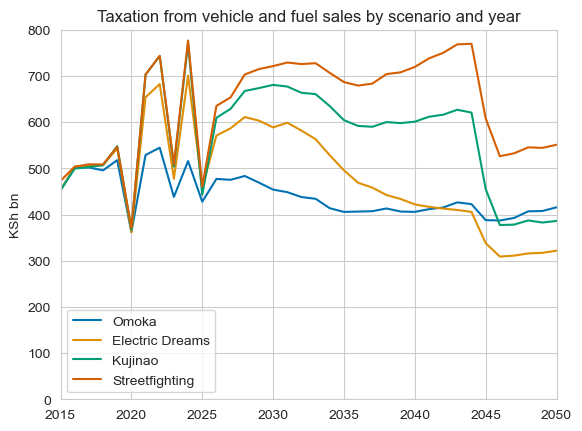

In [7]:
legend_labels = {'omoka':'Omoka', 'electricdreams': 'Electric Dreams', 'kujinao': 'Kujinao', 'streetfighting': 'Streetfighting'}

fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

cnt = 0
for scenario in scenarios:
    ax.plot(range(2015, 2051), chart_data[scenario], color=clrs[cnt], label=legend_labels[scenario.lower()])
    
    cnt += 1
    
ax.legend()
ax.set_ylabel('KSh bn')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Taxation from vehicle and fuel sales by scenario and year')

plt.savefig('taxation_vehicle_and_fuel_sales.pdf')

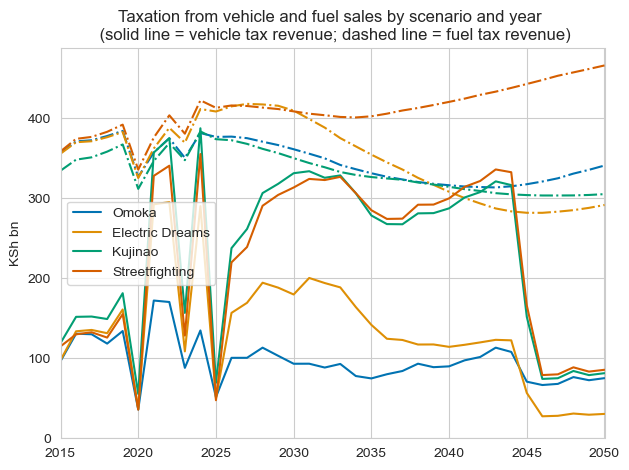

In [8]:
# separate lines 
fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

lnstls = ['-','--',':','.-']

cnt = 0
for scenario in scenarios:
    ax.plot(range(2015, 2051), vehiclesales_chart_data[scenario], color=clrs[cnt], label=legend_labels[scenario.lower()], linestyle = '-')
    ax.plot(range(2015, 2051), fueltax_chart_data[scenario], color=clrs[cnt], linestyle = '-.')
    
    cnt += 1
    
    
    
ax.legend()
ax.set_ylabel('KSh bn')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Taxation from vehicle and fuel sales by scenario and year \n (solid line = vehicle tax revenue; dashed line = fuel tax revenue)')

fig.tight_layout()

plt.savefig('taxation_vehicle_and_fuel_sales-separatelines.pdf')

In [9]:
fuel_tax

,FuelPriceID,CountryID,FuelID,FuelTypeID,BasicCost,Duty,ValueAddedTax
0,1,9,1,1,0.666667,0.333333,1.16
1,57,9,2,1,0.726667,0.146667,1.16
2,113,9,3,1,0.666667,0.333333,1.16
3,169,9,4,1,0.726667,0.146667,1.16
4,225,9,5,1,0.666667,0.166667,1.08
5,281,9,6,3,0.666667,0.333333,1.16
6,337,9,7,3,0.666667,0.166667,1.16
7,393,9,8,3,0.666667,0.166667,1.16
8,449,9,10,2,0.666667,0.083333,1.08
9,505,9,11,3,0.666667,0.083333,1.08
